In [1]:
import os
if os.path.exists('/Volumes'):
    pathprefix = '/Volumes/ahg_regevdata'
else: 
    pathprefix = '/ahg/regevdata'
filepath = '%s/projects/olfaction_sc/PA_amplicon/fastq/PA_amplicon' %pathprefix

In [2]:
# import sample sheet and length params
import pandas as pd
df_sample = pd.read_csv('sample_sheet.csv')
df_min_len = pd.read_csv('gene_min_length.csv')

In [3]:
# curate FASTQ file names corresponding to each sample
def get_sample_sheet(): 
    fastqs = os.listdir(filepath)
    fastqs.sort()
    for f in fastqs: 
        if not f.startswith('blank'):
            locus, sample, spacer, read, extension = f.split('_')
            sample_row = (df_sample['literal_gene']==locus) & (df_sample['sample']==sample)
            if read=='R1':
                df_sample.loc[sample_row,'read1'] = f
            elif read=='R2': 
                df_sample.loc[sample_row,'read2'] = f

In [4]:
def get_length_thresh(row): 
    a = df_min_len[df_min_len['Gene']==row['gene']]['Min_len_R1']
    b = df_min_len[df_min_len['Gene']==row['gene']]['Min_len_R2']
    return int(a), int(b)

# Processing

## filter and trim

In [5]:
# create output dirs for cutadapt
def run_cutadapt(df): 
    for idx, row in df.iterrows():

        dir_name = row['gene']+'_'+row['sample_type']
        out_dir = "cutadapt/"+dir_name
        print(dir_name)

        !mkdir -p cutadapt/$dir_name

        in_R1 = filepath+'/'+row['read1']
        in_R2 = filepath+'/'+row['read2']
        q_R1, q_R2 = get_length_thresh(row)

        !cutadapt --pair-filter=any -q 30 -m $q_R1:$q_R2 -a AGATCGGAAGAG -A AGATCGGAAGAG \
            -o $out_dir/trimmed_R1.fastq -p $out_dir/trimmed_R2.fastq $in_R1 $in_R2

In [10]:
# rerun = df_sample[df_sample['gene'].isin(['oprD','ampR','ampD_P42'])]
rerun = df_sample[df_sample['gene'].isin(['ampD_P09'])]

In [11]:
run_cutadapt(rerun)

ampD_P09_t1
This is cutadapt 3.3 with Python 3.8.3
Command line parameters: --pair-filter=any -q 30 -m 97:140 -a AGATCGGAAGAG -A AGATCGGAAGAG -o cutadapt/ampD_P09_t1/trimmed_R1.fastq -p cutadapt/ampD_P09_t1/trimmed_R2.fastq /Volumes/ahg_regevdata/projects/olfaction_sc/PA_amplicon/fastq/PA_amplicon/ampD_09SP1_S21_R1_001.fastq /Volumes/ahg_regevdata/projects/olfaction_sc/PA_amplicon/fastq/PA_amplicon/ampD_09SP1_S21_R2_001.fastq
Processing reads on 1 core in paired-end mode ...
[8=----------] 00:00:01        15,414 reads  @     78.2 µs/read;   0.77 M reads/minute
Finished in 1.72 s (111 µs/read; 0.54 M reads/minute).

=== Summary ===

Total read pairs processed:             15,414
  Read 1 with adapter:                   2,610 (16.9%)
  Read 2 with adapter:                   2,588 (16.8%)
Pairs that were too short:               9,141 (59.3%)
Pairs written (passing filters):         6,273 (40.7%)

Total basepairs processed:     4,624,200 bp
  Read 1:     2,312,100 bp
  Read 2:     2,312,1

ampD_P09_MUT
This is cutadapt 3.3 with Python 3.8.3
Command line parameters: --pair-filter=any -q 30 -m 97:140 -a AGATCGGAAGAG -A AGATCGGAAGAG -o cutadapt/ampD_P09_MUT/trimmed_R1.fastq -p cutadapt/ampD_P09_MUT/trimmed_R2.fastq /Volumes/ahg_regevdata/projects/olfaction_sc/PA_amplicon/fastq/PA_amplicon/ampD_09SP4-24_S23_R1_001.fastq /Volumes/ahg_regevdata/projects/olfaction_sc/PA_amplicon/fastq/PA_amplicon/ampD_09SP4-24_S23_R2_001.fastq
Processing reads on 1 core in paired-end mode ...
[8<----------] 00:00:00        13,033 reads  @     74.3 µs/read;   0.81 M reads/minute
Finished in 1.44 s (110 µs/read; 0.54 M reads/minute).

=== Summary ===

Total read pairs processed:             13,033
  Read 1 with adapter:                     866 (6.6%)
  Read 2 with adapter:                     855 (6.6%)
Pairs that were too short:               7,321 (56.2%)
Pairs written (passing filters):         5,712 (43.8%)

Total basepairs processed:     3,909,900 bp
  Read 1:     1,954,950 bp
  Read 2:     

##  merge paired reads

In [ ]:
for idx, row in df_sample.iterrows():
    
    dir_name = row['gene']+'_'+row['sample_type']
    out_dir = "cutadapt/"+dir_name
    print(dir_name)
    
    !vsearch --fastq_mergepairs $out_dir/trimmed_R1.fastq --reverse $out_dir/trimmed_R2.fastq --fastqout $out_dir/merged.fastq

# Analyze variant frequencies

In [14]:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from align_merged_reads import *

samples_df = get_sample_sheet()
filepath, tablespath = get_path() 
df_min_len, primer_table = load_sample_tables()

In [6]:
gene_var_cts = extract_variant_freqs(samples_df)

# separate the two mexR mutations
gene_var_cts['mexR_1'] = gene_var_cts['mexR'][['t1','t2','WT','MUT1']]
gene_var_cts['mexR_1'].rename(columns={'MUT1':'MUT'}, inplace=True)
gene_var_cts['mexR_2'] = gene_var_cts['mexR'][['t1','t2','WT','MUT2']]
gene_var_cts['mexR_2'].rename(columns={'MUT2':'MUT'}, inplace=True)
gene_var_cts.pop('mexR',None)

genes = list(gene_var_cts.keys())

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [7]:
import statsmodels.api as sm
import statsmodels.stats as sms

# normalize to frequencies; replace NaN with 0
gene_var_freq = gene_var_cts.copy()
upper_lim = gene_var_cts.copy()
lower_lim = gene_var_cts.copy()
wilson_CI = gene_var_cts.copy()

for gene in genes: 
    gene_var_freq[gene] = 100*gene_var_freq[gene]/gene_var_freq[gene].sum()
    background = gene_var_freq[gene][gene_var_freq[gene].max(axis=1)<0.8].index
    gene_var_freq[gene].drop(background, inplace=True) 
    gene_var_cts[gene].drop(background, inplace=True)
    
    gene_var_freq[gene].fillna(0, inplace=True)
    gene_var_cts[gene].fillna(0, inplace=True)
    
    gene_var_freq[gene] = 100*gene_var_cts[gene]/gene_var_cts[gene].sum()
    
    # calculate 2*std 
#     stdx2 = 2*(gene_var_cts[gene]**(0.5))
#     norm_factor = gene_var_cts[gene].sum()
#     upper_lim[gene] = 100*(gene_var_cts[gene] + stdx2)/norm_factor
#     lower_lim[gene] = 100*(gene_var_cts[gene] - stdx2)/norm_factor
    
    # calculate C.I.
    a, b = sms.proportion.proportion_confint(gene_var_cts[gene],
                                                        gene_var_cts[gene].sum(),
                                                        method='wilson')
    a.columns = gene_var_cts[gene].columns
    b.columns = gene_var_cts[gene].columns
    lower_lim[gene] = 100*a
    upper_lim[gene] = 100*b

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/stats/proportion.py:90: RuntimeWarning: invalid value encountered in true_divide
  q_ = count * 1. / nobs
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/stats/proportion.py:135: RuntimeWarning: divide by zero encountered in true_divide
  denom = 1 + crit2 / nobs
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/stats/proportion.py:136: RuntimeWarning: divide by zero encountered in true_divide
  center = (q_ + crit2 / (2 * nobs)) / denom
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/stats/proportion.py:137: RuntimeWarning: divide by zero encountered in true_divide
  dist = crit * np.sqrt(q_ * (1. - q_) / nobs + crit2 / (4. * nobs**2))


In [15]:
# # reshape data
# plot_df = dict.fromkeys(genes, pd.DataFrame(columns=['variant','sample_type','mean','upper','lower']))
# for gene in genes: 
#     for idx, row in gene_var_freq[gene].iterrows(): 
#         for timept in row.index: 
#             mean_val = gene_var_freq[gene].loc[idx,timept]
#             upper_val = upper_lim[gene].loc[idx,timept]
#             lower_val = lower_lim[gene].loc[idx,timept]
#             plot_df[gene] = plot_df[gene].append({'variant':idx,
#                                  'sample_type':timept,
#                                  'mean':mean_val,
#                                  'upper':upper_val-mean_val,
#                                  'lower':mean_val-lower_val},
#                                 ignore_index=True)
#         plot_df[gene].fillna(0, inplace=True)

## load colony based frequencies

In [8]:
colony_freqs = load_colony_freqs()
colony_freqs.set_index('locus', inplace=True)

In [9]:
a,b = sms.proportion.proportion_confint(colony_freqs['t1_mut'],
                                         colony_freqs['t1_total'],
                                         method='wilson')
colony_freqs['t1_lerr'], colony_freqs['t1_uerr'] = 100*a, 100*b

c,d = sms.proportion.proportion_confint(colony_freqs['t2_mut'],
                                         colony_freqs['t2_total'],
                                         method='wilson')
colony_freqs['t2_lerr'], colony_freqs['t2_uerr'] = 100*c, 100*d

## plot freq changes over time

In [10]:
def set_mut_wt_variant(df): 
    wt_i = df['WT'].argmax()
    wt = df.index[wt_i]
    
    if 'MUT' in df.columns:
        if sum(df['MUT'])>0: 
            mut_i = df['MUT'].argmax()
            mut = df.index[mut_i]
        else: 
            print('encountered NaN MUTS')
            import numpy as np
            mut = df.index[~df.index.isin([wt])].values[0]
            mut_i = np.where(mut)[0][0]
        
    return wt, mut, wt_i, mut_i 

def get_asymm_error(dfl, dfu, df, var_idx): 
    if var_idx is not list:
        asymmetric_error = [list(df.iloc[var_idx] - dfl.iloc[var_idx]), 
                            list(dfu.iloc[var_idx] - df.iloc[var_idx])]
    
    elif len(var_idx)>1: 
        for i in var_idx:
            asymmetric_error = [list(df_l[plot_types].iloc[i]), 
                                list(df_u[plot_types].iloc[i])]
            print(asymmetric_error)
            
    return asymmetric_error

def get_plot_vals(df, var_idx): 
    if var_idx is not list: 
        return list(df.iloc[var_idx])
    elif len(var_idx)>1: 
        return list(df.iloc[var_idx])
    
def get_colony_freq_err(df): 
    x = [[df['t1_freq']-df['t1_lerr'], df['t2_freq']-df['t2_lerr']], 
         [df['t1_uerr']-df['t1_freq'], df['t2_uerr']-df['t2_freq']]]
    return x

In [16]:
def plot_function(genes, gvc, gvf, patient, plot_colony_err=True):
    plot_types = ['t1','t2']
    
    def pat_lims(patient): 
        if patient=='P01': 
            yticks = [0,20,40,60]
            ylims = dict.fromkeys(genes, yticks)
        elif patient=='P09':
            yticks = [0,10,20]
            ylims = dict.fromkeys(genes, yticks)
        elif patient=='P42': 
            ylims = {'ampR':[0,100], 'mexR_1':[0,10,20], 'mexR_2':[0,10,20], 'PA0810':[0,10,20]}
        elif patient=='P13': 
            yticks = [0,30,60]
            ylims = {genes[0]:yticks}
        elif patient=='P14': 
            yticks = [0,70]
            ylims = {genes[0]:yticks}
            
        return ylims
    
    def plot_gene(gene, ax_h, yvals, colony_err=True): 
        if colony_err: 
            c_err = get_colony_freq_err(colony_freqs.loc[gene])
        else: 
            c_err = [0,0]
            
        df = gvf[gene]
        df_u = upper_lim[gene]
        df_l = lower_lim[gene]

        WT, MUT, WT_i, MUT_i = set_mut_wt_variant(df)
        mut_e = get_asymm_error(df_l[plot_types], df_u[plot_types], df[plot_types], MUT_i)

        ax_h.errorbar(plot_types, 
                    get_plot_vals(df[plot_types],MUT_i),
                    mut_e, 
                    marker='o',
                    ms=5, mfc='k', mec='k',
                    color='k',
                    capsize=8, capthick=2)
        ax_h.errorbar(plot_types, 
                    colony_freqs.loc[gene,['t1_freq','t2_freq']], 
                    c_err,
                    marker='x', 
                    ms=10,
                    linestyle='--',
                    color='gray', 
                    capsize=0, 
                    capthick=2)
        ax_h.set_xlim([-0.5,1.5])
#         ax_h.set_ylim([-1,max(yvals)])
        ax_h.set_title(gene, fontsize=16)
        ax_h.set_xticklabels(['t1','t2'], fontsize=14)
        ax_h.set_yticks(yvals)
        ax_h.set_yticklabels(yvals, fontsize=14)
        return ax
    
    # __ execute __ #
    ylim_dict = pat_lims(patient)
    
    if len(genes)>1:
        fig, axs = plt.subplots(1,len(genes),figsize=(4*len(genes), 4)) #,sharey=True)        
        for gene, ax in zip(genes, axs):
            print(ylim_dict[gene])
            ax = plot_gene(gene, ax, ylim_dict[gene], colony_err=plot_colony_err)
            
        fig.text(0.5, -0.02, 'Time point', ha='center', fontsize=16)
        fig.text(0, 0.5, 'Mutation frequency (%)', va='center', rotation='vertical', fontsize=16)
        fig.show()
        if plot_colony_err: 
            fig.savefig('figures/amplicon_seq1_%s_muts.pdf' %patient, bbox_inches='tight')
        else: 
            fig.savefig('figures/amplicon_seq1_%s_muts_no_colony_err.pdf' %patient, bbox_inches='tight')
        
    else: 
        fig, ax = plt.subplots(1,1,figsize=(4,4))
        ax = plot_gene(genes[0], ax, ylim_dict[genes[0]], colony_err=plot_colony_err)
        ax.set_xlabel('Time point', fontsize=16)
        ax.set_ylabel('Mutation frequency (%)', fontsize=16)
        if plot_colony_err: 
            fig.savefig('figures/amplicon_seq1_%s_muts.pdf' %patient, bbox_inches='tight')
        else: 
            fig.savefig('figures/amplicon_seq1_%s_muts_no_colony_err.pdf' %patient, bbox_inches='tight')

In [11]:
P01 = ['nalD', 'anmK', 'sltB1_P01']
P09 = ['oprD','sltB1_P09','ampD_P09']
P42 = ['ampR','mexR_1','mexR_2','PA0810'] #ampD_P42
P13 = ['sulP']
P14 = ['wbpL']

In [12]:
gene_var_freq['sltB1_P01']

,t1,t2,MUT,WT
CAGGCGGGGGA,92.643611,54.59285,0.103573,99.957054
CAGGCGGGGGG,7.356389,45.40715,99.896427,0.042946


[0, 100]
encountered NaN MUTS
[0, 10, 20]
[0, 10, 20]
[0, 10, 20]


<ipython-input-16-cdba3bb10d49>:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_h.set_xticklabels(['t1','t2'], fontsize=14)
<ipython-input-16-cdba3bb10d49>:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


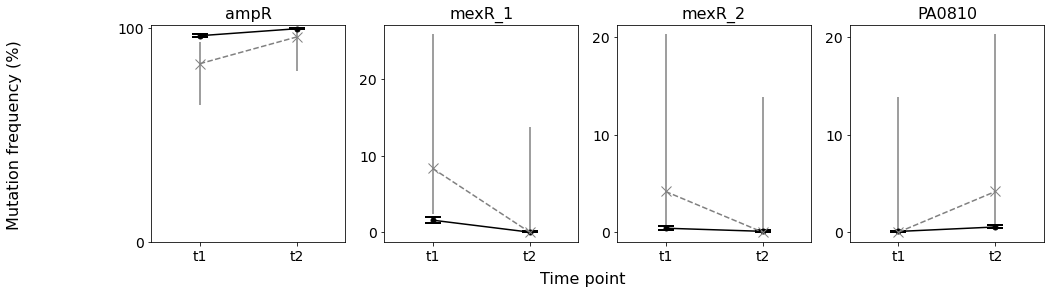

In [17]:
plot_function(P42, gene_var_cts, gene_var_freq, 'P42', plot_colony_err=True)

## plot UMIs

  UMI_freq    cts time
0        2     12   t1
1        1  11827   t1
0        2     17   t2
1        1  24825   t2
  UMI_freq   cts time
0        2     1   t1
1        1  4140   t1
0        2     1   t2
1        1  4549   t2
  UMI_freq   cts time
0        1  3469   t1
1        2     0   t1
0        1  4113   t2
1        2     0   t2
  UMI_freq   cts time
0        2     1   t1
1        1  2892   t1
0        2     3   t2
1        1  3354   t2
  UMI_freq   cts time
0        1  6256   t1
1        2     0   t1
0        2     2   t2
1        1  5649   t2
  UMI_freq   cts time
0        2     2   t1
1        1  3825   t1
0        2     1   t2
1        1  3621   t2
  UMI_freq   cts time
0        2     3   t1
1        1  9581   t1
0        2     1   t2
1        1  7232   t2


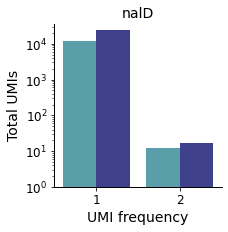

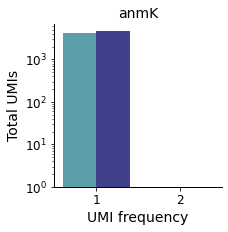

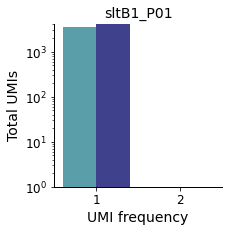

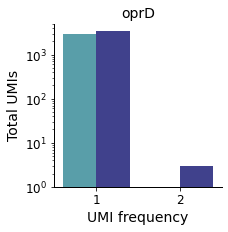

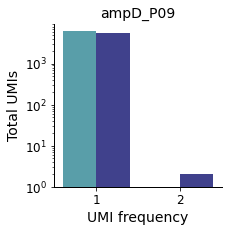

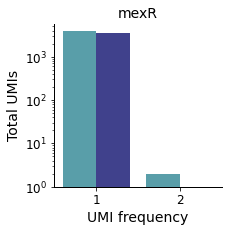

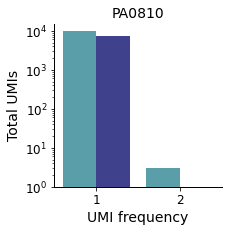

In [19]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as df
    
figdir = '/Users/hchung/Dropbox/projects/kishony-acute-infection/analysis_assembly/figures'

def get_gene_time_UMI_cts(gene, t):
    cts = []
    UMI_file = 'cutadapt/%s_%s/UMIstats.txt' %(gene, t)
    fh = open(UMI_file, 'r')
    Lines = fh.readlines()
    for line in Lines: 
        ct = line.strip().split(' ')
        cts.append(int(ct[0]))
    return cts

genes_analysis = ['oprD','ampD_P09','PA0810','nalD','anmK','sltB1_P01','mexR']
times = ['t1','t2']

for gene in genes_analysis:
    df_plot = pd.DataFrame([], columns=['UMI_freq','cts','time'])
    
    for t in times: 
        cts = get_gene_time_UMI_cts(gene, t)
        ct_dict = Counter(cts)
        if 2 not in ct_dict.keys(): 
            ct_dict[2] = 0
        df = pd.DataFrame(list(ct_dict.items()), columns=['UMI_freq','cts'])
        df['time'] = t
        df_plot = pd.concat([df_plot, df])
        
    fig, ax = plt.subplots(figsize=(3,3))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.set_yscale('log')
    ax.tick_params(labelsize=12)
    g = sns.barplot(x='UMI_freq',y='cts',data=df_plot,
                hue='time',ax=ax,palette=['#4ca8b6','#333599'])
    g.legend_.remove()
    ax.set_ylim(bottom=1)
    plt.title(gene, fontsize=14)
    plt.ylabel('Total UMIs', fontsize=14)
    plt.xlabel('UMI frequency', fontsize=14)
    plt.savefig('%s/amplicon_seq_UMI_cts_%s.pdf' %(figdir, gene), bbox_inches='tight')
    
    print(df_plot)
